In [19]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
# Dependencies
import pytz
import datetime as dt
from datetime import datetime
import dateparser
import gmaps
import numpy as np
import pandas as pd
import requests
import time
from pprint import pprint 
from scipy.stats import linregress
import scipy.stats as stats
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from suntime import Sun, SunTimeException
import os
import json
import urllib.request


In [21]:
accident_data_to_load ="../Resources/US_Accidents_May19.csv"
accidents_data_df = pd.read_csv(
    accident_data_to_load)

# Visualize
accidents_data_df = accidents_data_df.reset_index()
accidents_data_df.set_index('ID', inplace=True)
accidents_data_df.head()


,index,State,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Number,...,Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Astronomical_Twilight
ID,,,,,,,,,,,,,,,,,,,,,
A-1,0,OH,3,2/8/16 5:46,2/8/16 11:00,39.865147,-84.058723,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,...,29.68,10.0,Calm,NaN,0.02,Light Rain,False,Night,Night,Night
A-2,1,OH,2,2/8/16 6:07,2/8/16 6:37,39.928059,-82.831184,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,2584.0,...,29.65,10.0,Calm,NaN,0.00,Light Rain,False,Night,Night,Day
A-3,2,OH,2,2/8/16 6:49,2/8/16 7:19,39.063148,-84.032608,0.01,Accident on OH-32 State Route 32 Westbound at ...,NaN,...,29.67,10.0,SW,3.5,NaN,Overcast,True,Night,Night,Day
A-4,3,OH,3,2/8/16 7:23,2/8/16 7:53,39.747753,-84.205582,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,...,29.64,9.0,SW,4.6,NaN,Mostly Cloudy,False,Night,Day,Day
A-5,4,OH,2,2/8/16 7:39,2/8/16 8:09,39.627781,-84.188354,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,NaN,...,29.65,6.0,SW,3.5,NaN,Mostly Cloudy,True,Day,Day,Day


In [22]:
#Taking only the interstates
accidents_data_df['hwy'] = accidents_data_df['Street'].str.split("-", n = 1, expand = True)[0].str.contains("I")== True
accidents_data_df.head()

,index,State,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Number,...,Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Astronomical_Twilight,hwy
ID,,,,,,,,,,,,,,,,,,,,,
A-1,0,OH,3,2/8/16 5:46,2/8/16 11:00,39.865147,-84.058723,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,...,10.0,Calm,NaN,0.02,Light Rain,False,Night,Night,Night,True
A-2,1,OH,2,2/8/16 6:07,2/8/16 6:37,39.928059,-82.831184,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,2584.0,...,10.0,Calm,NaN,0.00,Light Rain,False,Night,Night,Day,False
A-3,2,OH,2,2/8/16 6:49,2/8/16 7:19,39.063148,-84.032608,0.01,Accident on OH-32 State Route 32 Westbound at ...,NaN,...,10.0,SW,3.5,NaN,Overcast,True,Night,Night,Day,False
A-4,3,OH,3,2/8/16 7:23,2/8/16 7:53,39.747753,-84.205582,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,...,9.0,SW,4.6,NaN,Mostly Cloudy,False,Night,Day,Day,True
A-5,4,OH,2,2/8/16 7:39,2/8/16 8:09,39.627781,-84.188354,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,NaN,...,6.0,SW,3.5,NaN,Mostly Cloudy,True,Day,Day,Day,False


In [23]:
interstate_df = accidents_data_df.loc[accidents_data_df['hwy'] == True]
interstate_df.head()

,index,State,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Number,...,Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Astronomical_Twilight,hwy
ID,,,,,,,,,,,,,,,,,,,,,
A-1,0,OH,3,2/8/16 5:46,2/8/16 11:00,39.865147,-84.058723,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,...,10.0,Calm,NaN,0.02,Light Rain,False,Night,Night,Night,True
A-4,3,OH,3,2/8/16 7:23,2/8/16 7:53,39.747753,-84.205582,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,...,9.0,SW,4.6,NaN,Mostly Cloudy,False,Night,Day,Day,True
A-12,11,OH,3,2/8/16 8:21,2/8/16 8:51,39.932709,-82.830910,0.01,One lane blocked due to accident on I-70 Westb...,NaN,...,3.0,SSW,4.6,0.02,Light Rain,False,Day,Day,Day,True
A-27,26,OH,2,2/8/16 12:52,2/8/16 13:37,39.733219,-84.159653,0.00,Accident on Irving Ave at Wilmington Ave.,1240.0,...,7.0,West,9.2,0.00,Light Snow,True,Day,Day,Day,True
A-50,49,OH,3,2/9/16 6:41,2/9/16 7:11,39.773193,-84.187454,0.01,Accident on I-75 Northbound at Exits 54A 54B O...,NaN,...,4.0,SW,11.5,NaN,Light Snow,False,Night,Night,Day,True


In [24]:
#Extract last letter of a string from a Pandas column to get the direction
interstate_df['Direction'] = interstate_df['Street'].str.strip().str[-1]
interstate_df.head()

,index,State,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Number,...,Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Astronomical_Twilight,hwy,Direction
ID,,,,,,,,,,,,,,,,,,,,,
A-1,0,OH,3,2/8/16 5:46,2/8/16 11:00,39.865147,-84.058723,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,...,Calm,NaN,0.02,Light Rain,False,Night,Night,Night,True,E
A-4,3,OH,3,2/8/16 7:23,2/8/16 7:53,39.747753,-84.205582,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,...,SW,4.6,NaN,Mostly Cloudy,False,Night,Day,Day,True,S
A-12,11,OH,3,2/8/16 8:21,2/8/16 8:51,39.932709,-82.830910,0.01,One lane blocked due to accident on I-70 Westb...,NaN,...,SSW,4.6,0.02,Light Rain,False,Day,Day,Day,True,E
A-27,26,OH,2,2/8/16 12:52,2/8/16 13:37,39.733219,-84.159653,0.00,Accident on Irving Ave at Wilmington Ave.,1240.0,...,West,9.2,0.00,Light Snow,True,Day,Day,Day,True,e
A-50,49,OH,3,2/9/16 6:41,2/9/16 7:11,39.773193,-84.187454,0.01,Accident on I-75 Northbound at Exits 54A 54B O...,NaN,...,SW,11.5,NaN,Light Snow,False,Night,Night,Day,True,S


In [25]:
interstate_df['hwy'] = interstate_df['Direction'].str.contains("E|W|N|S")== True
interstate_df.head()


,index,State,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Number,...,Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Astronomical_Twilight,hwy,Direction
ID,,,,,,,,,,,,,,,,,,,,,
A-1,0,OH,3,2/8/16 5:46,2/8/16 11:00,39.865147,-84.058723,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,...,Calm,NaN,0.02,Light Rain,False,Night,Night,Night,True,E
A-4,3,OH,3,2/8/16 7:23,2/8/16 7:53,39.747753,-84.205582,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,...,SW,4.6,NaN,Mostly Cloudy,False,Night,Day,Day,True,S
A-12,11,OH,3,2/8/16 8:21,2/8/16 8:51,39.932709,-82.830910,0.01,One lane blocked due to accident on I-70 Westb...,NaN,...,SSW,4.6,0.02,Light Rain,False,Day,Day,Day,True,E
A-27,26,OH,2,2/8/16 12:52,2/8/16 13:37,39.733219,-84.159653,0.00,Accident on Irving Ave at Wilmington Ave.,1240.0,...,West,9.2,0.00,Light Snow,True,Day,Day,Day,False,e
A-50,49,OH,3,2/9/16 6:41,2/9/16 7:11,39.773193,-84.187454,0.01,Accident on I-75 Northbound at Exits 54A 54B O...,NaN,...,SW,11.5,NaN,Light Snow,False,Night,Night,Day,True,S


In [26]:
hwy_df = interstate_df.loc[interstate_df['hwy'] == True]
hwy_df.head()

,index,State,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Number,...,Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Astronomical_Twilight,hwy,Direction
ID,,,,,,,,,,,,,,,,,,,,,
A-1,0,OH,3,2/8/16 5:46,2/8/16 11:00,39.865147,-84.058723,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,...,Calm,NaN,0.02,Light Rain,False,Night,Night,Night,True,E
A-4,3,OH,3,2/8/16 7:23,2/8/16 7:53,39.747753,-84.205582,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,...,SW,4.6,NaN,Mostly Cloudy,False,Night,Day,Day,True,S
A-12,11,OH,3,2/8/16 8:21,2/8/16 8:51,39.932709,-82.830910,0.01,One lane blocked due to accident on I-70 Westb...,NaN,...,SSW,4.6,0.02,Light Rain,False,Day,Day,Day,True,E
A-50,49,OH,3,2/9/16 6:41,2/9/16 7:11,39.773193,-84.187454,0.01,Accident on I-75 Northbound at Exits 54A 54B O...,NaN,...,SW,11.5,NaN,Light Snow,False,Night,Night,Day,True,S
A-66,65,OH,3,2/9/16 8:23,2/9/16 8:53,39.622787,-84.229858,0.01,Accident on I-75 Southbound at I-675. Expect d...,NaN,...,WSW,9.2,0.00,Light Snow,False,Day,Day,Day,True,N


In [27]:
#converting the direction column to a list to check we get only teh valid direstions, N S E W
directionToList = hwy_df['Direction'].tolist()
#print(directionToList)

In [28]:
len(hwy_df)

209060

In [29]:
#extracting the accident date
hwy_df['Accident_Date'] = hwy_df['Start_Time'].str.split(" ", n = 1, expand = True)[0]
hwy_df.head()

,index,State,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Number,...,Wind_Speed(mph),Precipitation(in),Weather_Condition,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Astronomical_Twilight,hwy,Direction,Accident_Date
ID,,,,,,,,,,,,,,,,,,,,,
A-1,0,OH,3,2/8/16 5:46,2/8/16 11:00,39.865147,-84.058723,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,...,NaN,0.02,Light Rain,False,Night,Night,Night,True,E,2/8/16
A-4,3,OH,3,2/8/16 7:23,2/8/16 7:53,39.747753,-84.205582,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,...,4.6,NaN,Mostly Cloudy,False,Night,Day,Day,True,S,2/8/16
A-12,11,OH,3,2/8/16 8:21,2/8/16 8:51,39.932709,-82.830910,0.01,One lane blocked due to accident on I-70 Westb...,NaN,...,4.6,0.02,Light Rain,False,Day,Day,Day,True,E,2/8/16
A-50,49,OH,3,2/9/16 6:41,2/9/16 7:11,39.773193,-84.187454,0.01,Accident on I-75 Northbound at Exits 54A 54B O...,NaN,...,11.5,NaN,Light Snow,False,Night,Night,Day,True,S,2/9/16
A-66,65,OH,3,2/9/16 8:23,2/9/16 8:53,39.622787,-84.229858,0.01,Accident on I-75 Southbound at I-675. Expect d...,NaN,...,9.2,0.00,Light Snow,False,Day,Day,Day,True,N,2/9/16


In [30]:
#Converting date from string format to date format
hwy_df['Accident_Date'] = pd.to_datetime(hwy_df['Accident_Date'])
hwy_df['Accident_Date_No_Time'] = hwy_df['Accident_Date'].dt.date
hwy_df.head()

,index,State,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Number,...,Precipitation(in),Weather_Condition,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Astronomical_Twilight,hwy,Direction,Accident_Date,Accident_Date_No_Time
ID,,,,,,,,,,,,,,,,,,,,,
A-1,0,OH,3,2/8/16 5:46,2/8/16 11:00,39.865147,-84.058723,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,...,0.02,Light Rain,False,Night,Night,Night,True,E,2016-02-08,2016-02-08
A-4,3,OH,3,2/8/16 7:23,2/8/16 7:53,39.747753,-84.205582,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,...,NaN,Mostly Cloudy,False,Night,Day,Day,True,S,2016-02-08,2016-02-08
A-12,11,OH,3,2/8/16 8:21,2/8/16 8:51,39.932709,-82.830910,0.01,One lane blocked due to accident on I-70 Westb...,NaN,...,0.02,Light Rain,False,Day,Day,Day,True,E,2016-02-08,2016-02-08
A-50,49,OH,3,2/9/16 6:41,2/9/16 7:11,39.773193,-84.187454,0.01,Accident on I-75 Northbound at Exits 54A 54B O...,NaN,...,NaN,Light Snow,False,Night,Night,Day,True,S,2016-02-09,2016-02-09
A-66,65,OH,3,2/9/16 8:23,2/9/16 8:53,39.622787,-84.229858,0.01,Accident on I-75 Southbound at I-675. Expect d...,NaN,...,0.00,Light Snow,False,Day,Day,Day,True,N,2016-02-09,2016-02-09


In [31]:
hwy_df = hwy_df.drop(['hwy', 'Accident_Date'], axis=1)

In [32]:
hwy_df.head()

,index,State,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Number,...,Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Astronomical_Twilight,Direction,Accident_Date_No_Time
ID,,,,,,,,,,,,,,,,,,,,,
A-1,0,OH,3,2/8/16 5:46,2/8/16 11:00,39.865147,-84.058723,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,...,Calm,NaN,0.02,Light Rain,False,Night,Night,Night,E,2016-02-08
A-4,3,OH,3,2/8/16 7:23,2/8/16 7:53,39.747753,-84.205582,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,...,SW,4.6,NaN,Mostly Cloudy,False,Night,Day,Day,S,2016-02-08
A-12,11,OH,3,2/8/16 8:21,2/8/16 8:51,39.932709,-82.830910,0.01,One lane blocked due to accident on I-70 Westb...,NaN,...,SSW,4.6,0.02,Light Rain,False,Day,Day,Day,E,2016-02-08
A-50,49,OH,3,2/9/16 6:41,2/9/16 7:11,39.773193,-84.187454,0.01,Accident on I-75 Northbound at Exits 54A 54B O...,NaN,...,SW,11.5,NaN,Light Snow,False,Night,Night,Day,S,2016-02-09
A-66,65,OH,3,2/9/16 8:23,2/9/16 8:53,39.622787,-84.229858,0.01,Accident on I-75 Southbound at I-675. Expect d...,NaN,...,WSW,9.2,0.00,Light Snow,False,Day,Day,Day,N,2016-02-09


In [33]:
hwy_df = hwy_df.rename({'Accident_Date_No_Time':'Accident_Date'}, axis=1)
hwy_df.head()

,index,State,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Number,...,Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Astronomical_Twilight,Direction,Accident_Date
ID,,,,,,,,,,,,,,,,,,,,,
A-1,0,OH,3,2/8/16 5:46,2/8/16 11:00,39.865147,-84.058723,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,...,Calm,NaN,0.02,Light Rain,False,Night,Night,Night,E,2016-02-08
A-4,3,OH,3,2/8/16 7:23,2/8/16 7:53,39.747753,-84.205582,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,...,SW,4.6,NaN,Mostly Cloudy,False,Night,Day,Day,S,2016-02-08
A-12,11,OH,3,2/8/16 8:21,2/8/16 8:51,39.932709,-82.830910,0.01,One lane blocked due to accident on I-70 Westb...,NaN,...,SSW,4.6,0.02,Light Rain,False,Day,Day,Day,E,2016-02-08
A-50,49,OH,3,2/9/16 6:41,2/9/16 7:11,39.773193,-84.187454,0.01,Accident on I-75 Northbound at Exits 54A 54B O...,NaN,...,SW,11.5,NaN,Light Snow,False,Night,Night,Day,S,2016-02-09
A-66,65,OH,3,2/9/16 8:23,2/9/16 8:53,39.622787,-84.229858,0.01,Accident on I-75 Southbound at I-675. Expect d...,NaN,...,WSW,9.2,0.00,Light Snow,False,Day,Day,Day,N,2016-02-09


In [34]:
hwy_df['Accident_Time'] = hwy_df['Start_Time'].str.split(" ", n = 1, expand = True)[1]
hwy_df.head()

,index,State,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Number,...,Wind_Speed(mph),Precipitation(in),Weather_Condition,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Astronomical_Twilight,Direction,Accident_Date,Accident_Time
ID,,,,,,,,,,,,,,,,,,,,,
A-1,0,OH,3,2/8/16 5:46,2/8/16 11:00,39.865147,-84.058723,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,...,NaN,0.02,Light Rain,False,Night,Night,Night,E,2016-02-08,5:46
A-4,3,OH,3,2/8/16 7:23,2/8/16 7:53,39.747753,-84.205582,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,...,4.6,NaN,Mostly Cloudy,False,Night,Day,Day,S,2016-02-08,7:23
A-12,11,OH,3,2/8/16 8:21,2/8/16 8:51,39.932709,-82.830910,0.01,One lane blocked due to accident on I-70 Westb...,NaN,...,4.6,0.02,Light Rain,False,Day,Day,Day,E,2016-02-08,8:21
A-50,49,OH,3,2/9/16 6:41,2/9/16 7:11,39.773193,-84.187454,0.01,Accident on I-75 Northbound at Exits 54A 54B O...,NaN,...,11.5,NaN,Light Snow,False,Night,Night,Day,S,2016-02-09,6:41
A-66,65,OH,3,2/9/16 8:23,2/9/16 8:53,39.622787,-84.229858,0.01,Accident on I-75 Southbound at I-675. Expect d...,NaN,...,9.2,0.00,Light Snow,False,Day,Day,Day,N,2016-02-09,8:23


In [35]:
hwy_rush_hour_morning_df = hwy_df.copy()
hwy_rush_hour_evening_df = hwy_df.copy()
hwy_rest_of_work_hour_df = hwy_df.copy()
hwy_rest_of_the_day_df = hwy_df.copy()

In [37]:
rush_hour_morning_accidents = []
rush_hour_evening_accidents = []
rest_of_work_hour_accidents = []
rest_of_the_day = []

#rush hour is morning 7 to 10 am and evening 4 to 7 pm and rest of the work hour between 10 am and 4 pm
start_morning = dt.time(7, 0)
end_morning = dt.time(10, 0) 
start_evening = dt.time(16, 0)
end_evening = dt.time(19, 0)

for accident_time in hwy_rush_hour_morning_df.loc[:, 'Accident_Time']:
    #print(accident_time)
    accident_time_obj = datetime.strptime(accident_time, '%H:%M').time()
    #print(accident_time_obj)
    if(start_morning < accident_time_obj < end_morning):
        rush_hour_morning_accidents.append(accident_time_obj)
    elif(start_evening < accident_time_obj < end_evening):
        rush_hour_evening_accidents.append(accident_time_obj)
    elif(end_morning < accident_time_obj < start_evening):
        rest_of_work_hour_accidents.append(accident_time_obj)
    else:
        rest_of_the_day.append(accident_time_obj)
    


In [38]:
hwy_rush_hour_morning_df = hwy_rush_hour_morning_df.iloc[:len(rush_hour_morning_accidents), :]
hwy_rush_hour_evening_df = hwy_rush_hour_evening_df.iloc[:len(rush_hour_evening_accidents), :]
hwy_rest_of_work_hour_df = hwy_rest_of_work_hour_df.iloc[:len(rest_of_work_hour_accidents), :]
hwy_rest_of_the_day_df = hwy_rest_of_the_day_df.iloc[:len(rest_of_the_day), :]

In [39]:
hwy_rush_hour_morning_df['Rush_Hour_Morning_Accident_Time'] = rush_hour_morning_accidents
hwy_rush_hour_evening_df['Rush_Hour_Evening_Accident_Time'] = rush_hour_evening_accidents
hwy_rest_of_work_hour_df['Rest_Of_Work_Hour_Accident_Time'] = rest_of_work_hour_accidents
hwy_rest_of_the_day_df['Rest_Of_The_day_Accident_Time'] = rest_of_the_day

In [40]:
print(len(rush_hour_morning_accidents))
print(len(rush_hour_evening_accidents))
print(len(rest_of_work_hour_accidents))
print(len(rest_of_the_day))

48580
40703
62536
57241


In [56]:
def plot_bar(x,y, color):
    # this is for plotting purpose for each hour slot
    # Figure size
    plt.figure(figsize=(10,5))
    plt.style.use('ggplot')
    x_pos = [i for i, _ in enumerate(x)]
    plt.bar(x, y, color = color)
    plt.xlabel("Hour bins")
    plt.ylabel("accident count")
    plt.title('count of accidents at different time slots of the day')
    plt.xticks(x_pos, x, fontsize=10, rotation=30)

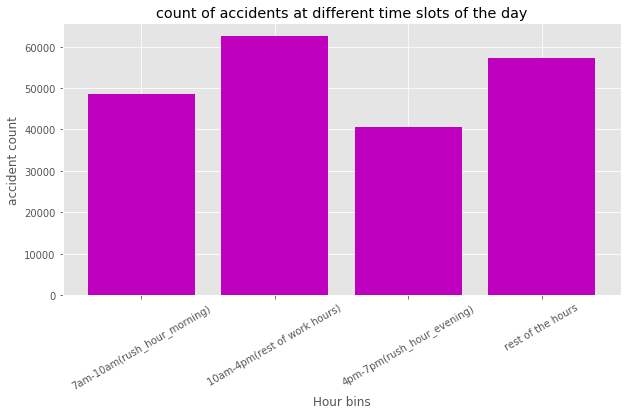

In [57]:
hour_bins = ['7am-10am(rush_hour_morning)','10am-4pm(rest of work hours)','4pm-7pm(rush_hour_evening)','rest of the hours']
accident_count = [len(rush_hour_morning_accidents), len(rest_of_work_hour_accidents), len(rush_hour_evening_accidents),len(rest_of_the_day)]
plot_bar(hour_bins, accident_count, 'm')
os.makedirs(os.path.join('output_data'),exist_ok=True)
plt.savefig(os.path.join('output_data',f'accident_count_vs_hour_bins.png'))

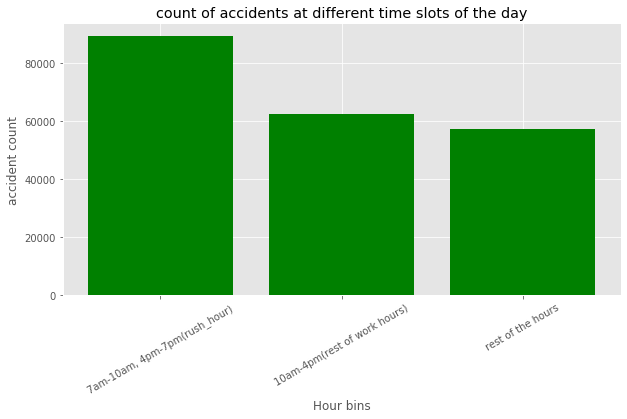

In [58]:
# plot total rush hour vs the other hours of the day
rush_hour_non_rush_bins = ['7am-10am, 4pm-7pm(rush_hour)','10am-4pm(rest of work hours)','rest of the hours']
accident_count = [len(rush_hour_morning_accidents)+ len(rush_hour_evening_accidents), len(rest_of_work_hour_accidents), len(rest_of_the_day)]
plot_bar(rush_hour_non_rush_bins, accident_count, 'green')
plt.savefig(os.path.join('output_data',f'accident_count_vs_rush_hour.png'))